# Курсовой проект для курса "Python для Data Science"

Задание для курсового проекта
Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:
1. Сдать проект нужно в течение 7 дней после окончания последнего вебинара.
2. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook.
3. Необходимо получить R2 > 0.6 на Private Leaderboard.
4. Укажите свой ник на kaggle

### Подключение библиотек и скриптов

In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели
import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [2]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

##### Пути к директориям и файлам

In [5]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### Загрузка данных

##### Описание датасета
<ul>
    <li>Id - идентификационный номер квартиры</li>
    <li>DistrictId - идентификационный номер района</li>
    <li>Rooms - количество комнат</li>
    <li>Square - площадь</li>
    <li>LifeSquare - жилая площадь</li>
    <li>KitchenSquare - площадь кухни</li>
    <li>Floor - этаж</li>
    <li>HouseFloor - количество этажей в доме</li>
    <li>HouseYear - год постройки дома</li>
    <li>Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности</li>
    <li>Social_1, Social_2, Social_3 - социальные показатели местности</li>
    <li>Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья</li>
    <li>Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров</li>
    <li>Price - цена квартиры</li>
</ul>

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df = reduce_mem_usage(train_df)
train_df.tail()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.453125
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.156250
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.906250
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.406250
9999,7202,94,1.0,35.815475,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.625000


In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df = reduce_mem_usage(test_df)
test_df.head()

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493908,42.568134,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463676,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837055,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [8]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


### Приведение типов

In [9]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [10]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
train_df['Ecology_2'] = train_df['Ecology_2'].astype(str)
train_df['Ecology_3'] = train_df['Ecology_3'].astype(str)
train_df['Shops_2'] = train_df['Shops_2'].astype(str)

## EDA и очистка данных 

Делаем EDA для:
<ol>
    <li>Исправления выбросов</li>
<li>Заполнения NaN</li>
<li>Идей для генерации новых фич</li>
</ol>

### Изучение целевой переменной

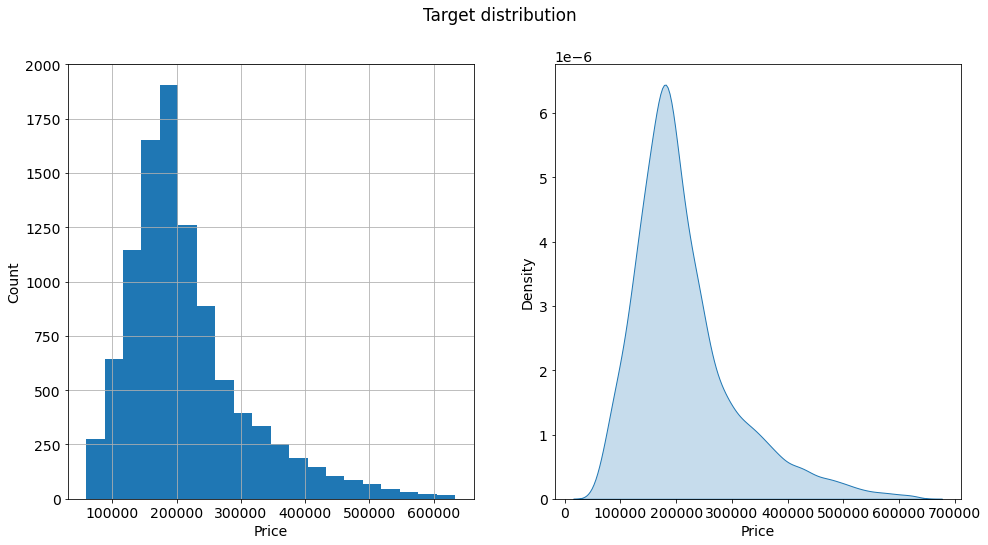

In [11]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Price'].hist(density=False, bins=20)
plt.ylabel('Count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Target distribution')
plt.show()

In [12]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]

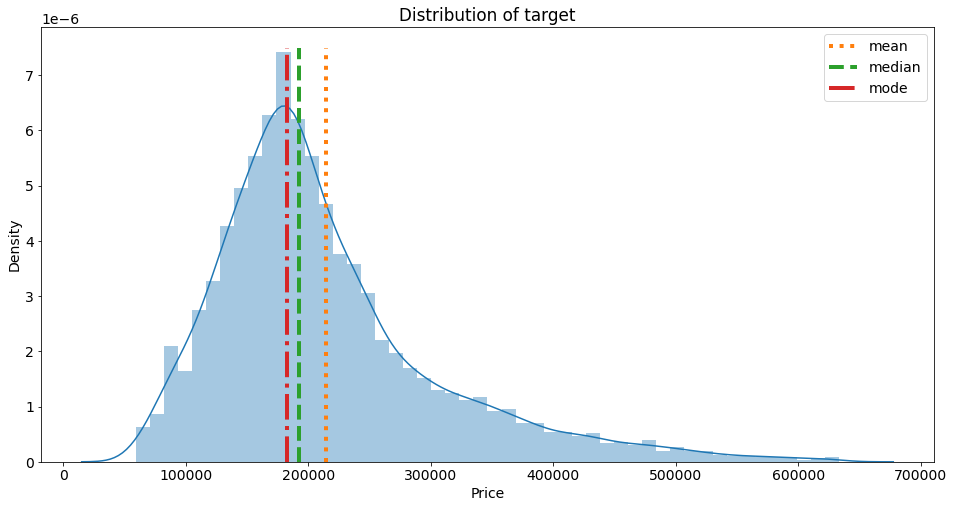

In [13]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=50)

y = np.linspace(0, 0.0000075, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of target')
plt.legend()
plt.show()

In [14]:
print(target_mean)
print(target_median)
print(target_mode)

214138.94
192269.65625
182938.08


### Анализ признаков

#### Матрица корреляции

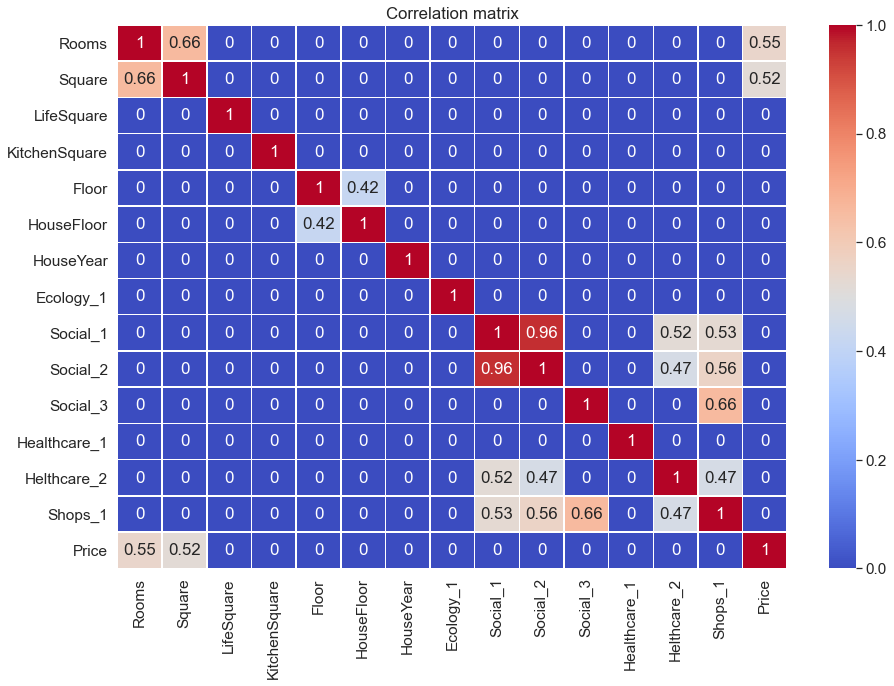

In [15]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

#### Количественные переменные

In [16]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [17]:
df_num_features = train_df[['Rooms', 'Square', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
                            'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Shops_1']]
df_num_features.head()

,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Shops_1
0,3.0,115.027313,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0
1,1.0,39.832523,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,0
2,3.0,78.342216,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,1
3,1.0,40.409908,1.0,10,22.0,1977,0.007122,1,264,0,NaN,1
4,2.0,64.285065,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,6


array([[<AxesSubplot:title={'center':'Rooms'}>,
        <AxesSubplot:title={'center':'Square'}>,
        <AxesSubplot:title={'center':'KitchenSquare'}>],
       [<AxesSubplot:title={'center':'Floor'}>,
        <AxesSubplot:title={'center':'HouseFloor'}>,
        <AxesSubplot:title={'center':'HouseYear'}>],
       [<AxesSubplot:title={'center':'Ecology_1'}>,
        <AxesSubplot:title={'center':'Social_1'}>,
        <AxesSubplot:title={'center':'Social_2'}>],
       [<AxesSubplot:title={'center':'Social_3'}>,
        <AxesSubplot:title={'center':'Healthcare_1'}>,
        <AxesSubplot:title={'center':'Shops_1'}>]], dtype=object)

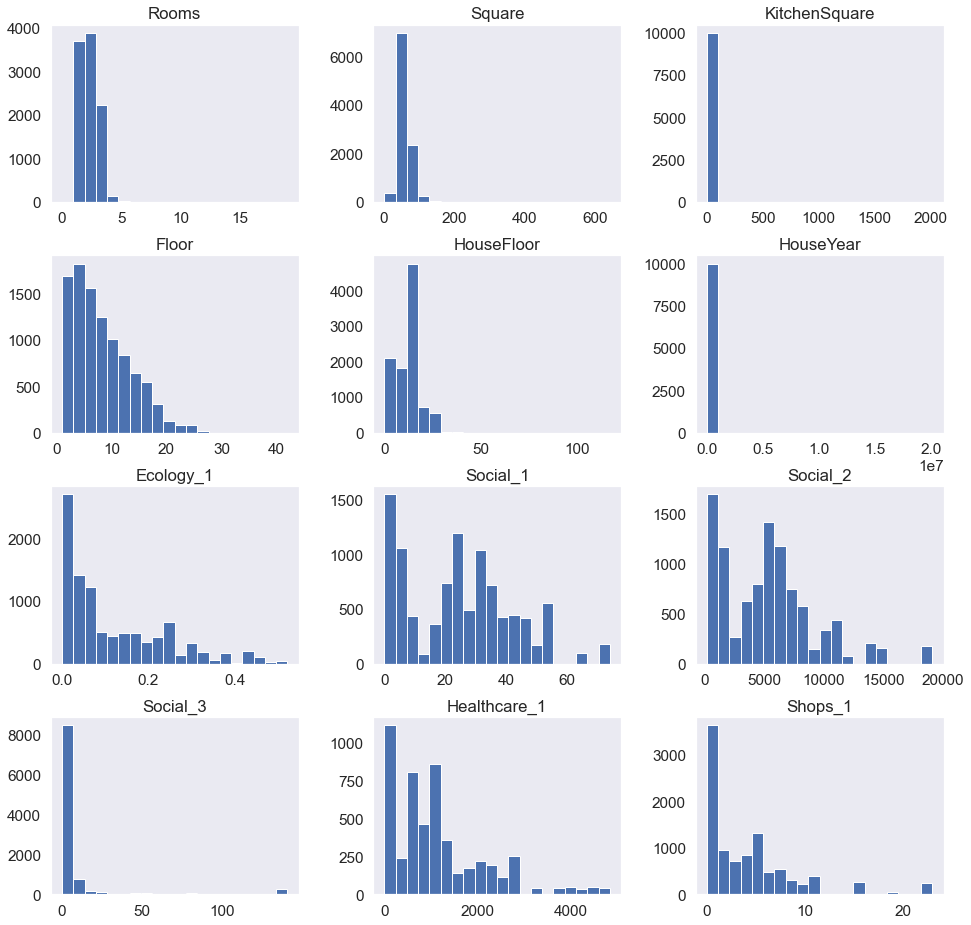

In [18]:
df_num_features.hist(figsize=(16, 16), bins=20, grid=False)

#### Номинативные переменные

In [19]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [20]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
205      1
117      1
199      1
196      1
209      1
Name: DistrictId, Length: 205, dtype: int64

In [21]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [22]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [23]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

#### Обработка выбросов

##### Rooms

In [24]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

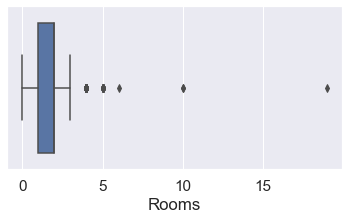

In [25]:
plt.figure(figsize=(6, 3))

sns.boxplot(train_df['Rooms'], whis=1.5)

plt.xlabel('Rooms')
plt.show()

In [26]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.875000,0
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.546875,0
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.718750,0
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.000000,0
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.093750,0


In [27]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [28]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

##### KitchenSquare

In [29]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
112.0        2
51.0         2
58.0         2
37.0         2
32.0         2
41.0         2
43.0         2
30.0         2
25.0         2
39.0         1
23.0         1
123.0        1
40.0         1
48.0         1
21.0         1
72.0         1
27.0         1
63.0         1
1970.0       1
29.0         1
66.0         1
2014.0       1
31.0         1
78.0         1
35.0         1
42.0         1
73.0         1
60.0         1
84.0         1
26.0         1
54.0         1
36.0         1
53.0         1
96.0         1
62.0         1
75.0         1
Name: KitchenSquare, dtype: int64

В настоящее время большая часть квартир в Москве имеет кухню площадью от 9 до 10 кв. м, говорится в пресс-релизе компании «Миэль». Такие квартиры формируют 27,6% городского рынка вторичного жилья. Еще 21% приходится на квартиры с кухнями от 11 до 15 кв. м, 20% составляют объекты с кухнями больше 15 кв. м. Доля квартир с кухнями менее 4 кв. м не превышает 0,4% от предложения в столице, убеждены риелторы.

https://realty.rbc.ru/news/577d0dec9a7947e548ea46be

С учетом информации из открытых источником, считаю целесообразным ограничить максимальную площадь кухни 20 кв. м.

In [30]:
condition = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > 20)
        
train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()
train_df.loc[(train_df['KitchenSquare'] <=2) & (train_df['Rooms'] ==1), 'KitchenSquare'] = 0

# Таким образом, мы определяем кваратиры - студии
train_df.loc[(train_df['KitchenSquare'] <=2) & (train_df['Rooms'] >1), 'KitchenSquare'] = 3 


In [31]:
train_df['KitchenSquare'].value_counts()

3.0     1840
0.0     1343
8.0     1306
5.0     1169
6.0     1086
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
14.0      51
4.0       39
15.0      31
16.0      16
20.0      14
17.0      12
19.0      11
18.0       6
Name: KitchenSquare, dtype: int64

##### HouseFloor, Floor

<function matplotlib.pyplot.show(close=None, block=None)>

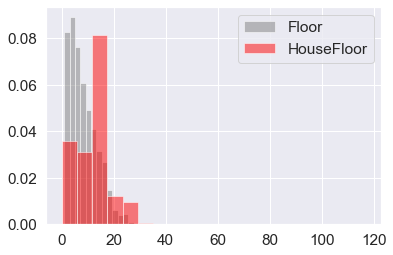

In [32]:
plt.hist(train_df['Floor'], bins=20, density = True, alpha=0.5, color='grey', label='Floor')
plt.hist(train_df['HouseFloor'], bins=20, density = True, alpha=0.5, color='red', label='HouseFloor')
plt.legend()
plt.show

In [33]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

“Меркурий Сити” - самый высокий небоскреб в Европе, который находится на территории ММДЦ “Москва-Сити”. Его высота  - 338, 8 м. Здание состоит из 75 этажей. Общая площадь этажей небоскреба 180 тыс. кв.м, из которых 86 тыс. кв.м предоставлены для офисных помещений класса А+, 20 тыс. кв. м - жилые апартаменты категории “люкс”.

Подробнее на РБК:
https://realty.rbc.ru/news/577d251a9a7947a78ce91fba

Соответственно, необходимо обработать следующие значения "датасета": 0, 99, 117

In [34]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = 1
train_df.loc[train_df['HouseFloor'] > 75, 'HouseFloor'] = train_df['HouseFloor'].median()

In [35]:
train_df['HouseFloor'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 36., 37., 38., 39., 40., 44., 45.,
       47., 48.], dtype=float32)

In [36]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [37]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1818

In [38]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [39]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   24,   25,   26,   33,   34,   37,   39,
            ...
            9931, 9938, 9940, 9950, 9953, 9960, 9968, 9970, 9975, 9996],
           dtype='int64', length=1818)

In [40]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [41]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

##### HouseYear

In [42]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int32

In [43]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = random.randint(1910, 2020)

In [44]:
train_df['HouseYear'].sort_values(ascending=False)

7955    2020
9400    2020
9091    2020
8296    2020
8664    2020
        ... 
7610    1916
6250    1914
2066    1912
2795    1912
6794    1910
Name: HouseYear, Length: 10000, dtype: int32

##### LifeSquare and Square 

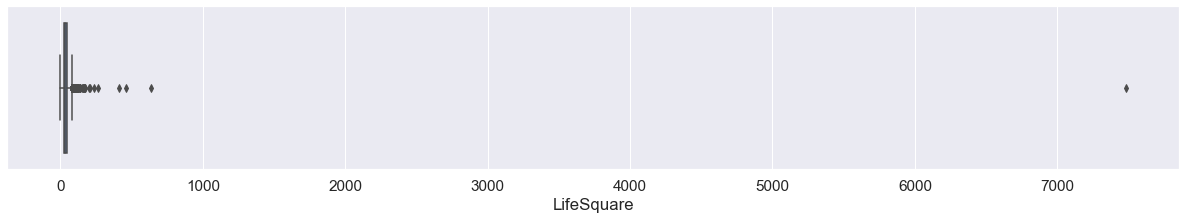

In [45]:
plt.figure(figsize=(21, 3))

sns.boxplot(train_df['LifeSquare'], whis=1.5)

plt.xlabel('LifeSquare')
plt.show()

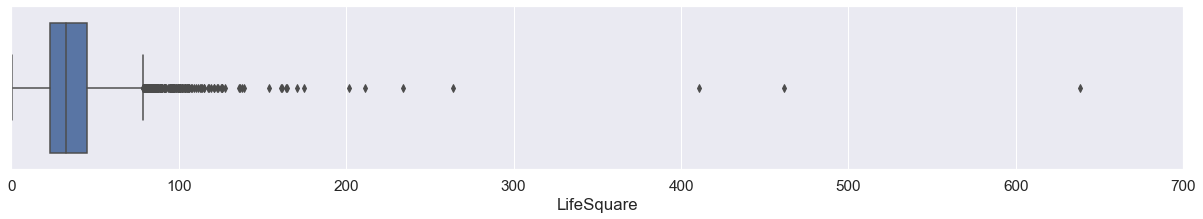

In [46]:
plt.figure(figsize=(21, 3))

figure = sns.boxplot(train_df['LifeSquare'], whis=1.5)
figure.set_xlim([0, 700])

plt.xlabel('LifeSquare')
plt.show()

In [47]:
train_df.loc[train_df['LifeSquare'] > 200].head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier
357,14990,23,2.0,48.449875,263.542023,5.0,3,5.0,1972,0.075779,...,6,1437,3,NaN,0,2,B,141780.234375,0,1
1776,16568,27,4.0,200.334534,201.627365,6.0,1,2.0,2013,0.041116,...,53,14892,4,NaN,1,4,B,528560.500000,0,0
1906,5548,86,5.0,275.645294,233.949310,6.0,12,37.0,2011,0.161976,...,31,7010,5,4508.0,3,7,B,455264.875000,0,0
5183,15886,85,3.0,78.059334,461.463623,10.0,12,16.0,1998,0.037178,...,52,11217,1,2300.0,1,7,B,394253.312500,0,0
7010,2307,102,1.0,409.425171,410.639740,10.0,4,4.0,2016,0.238617,...,26,3889,6,705.0,3,6,B,90470.429688,0,0
7644,7917,27,1.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,...,9,1892,0,NaN,0,1,B,302211.250000,1,0
8000,16550,27,3.0,81.694420,7480.592285,3.0,9,17.0,2016,0.017647,...,2,469,0,NaN,0,0,B,217357.500000,0,0
9229,11602,30,2.0,641.065186,638.163208,10.0,9,19.0,2019,0.000078,...,22,6398,141,1046.0,3,23,B,133529.687500,0,1


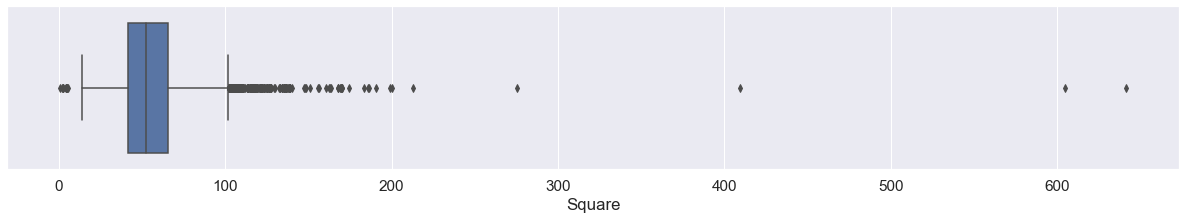

In [48]:
plt.figure(figsize=(21, 3))

sns.boxplot(train_df['Square'], whis=1.5)

plt.xlabel('Square')
plt.show()

In [49]:
train_df.loc[train_df['Square'] > 200].head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier
726,28,9,2.0,604.705994,NaN,3.0,17,18.0,1977,0.161532,...,25,5648,1,30.0,2,4,B,187717.250000,0,0
1776,16568,27,4.0,200.334534,201.627365,6.0,1,2.0,2013,0.041116,...,53,14892,4,NaN,1,4,B,528560.500000,0,0
1906,5548,86,5.0,275.645294,233.949310,6.0,12,37.0,2011,0.161976,...,31,7010,5,4508.0,3,7,B,455264.875000,0,0
7010,2307,102,1.0,409.425171,410.639740,10.0,4,4.0,2016,0.238617,...,26,3889,6,705.0,3,6,B,90470.429688,0,0
7644,7917,27,1.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,...,9,1892,0,NaN,0,1,B,302211.250000,1,0
9229,11602,30,2.0,641.065186,638.163208,10.0,9,19.0,2019,0.000078,...,22,6398,141,1046.0,3,23,B,133529.687500,0,1


In [50]:
train_df.loc[train_df['LifeSquare'] > 300, 'Rooms'] = 275

In [51]:
train_df.loc[train_df['Square'] > 300, 'Rooms'] = 300

#### Обработка пропусков

In [52]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare            2113
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
HouseFloor_outlier       0
dtype: int64

In [53]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027313,NaN,10.0
1,39.832523,23.169222,8.0
2,78.342216,47.671970,10.0
3,40.409908,NaN,0.0
4,64.285065,38.562515,9.0
5,62.528465,47.103832,6.0
6,33.938751,21.772930,9.0
7,50.391815,32.893257,8.0
8,46.887894,44.628132,0.0
9,79.867477,75.085129,3.0


###### LifeSquare

In [54]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

In [55]:
(train_df['LifeSquare'] > train_df['Square']).sum()

482

In [56]:
train_df['LifeSquare_outlier'] = 0
train_df.loc[train_df['LifeSquare'] > train_df['Square'], 'LifeSquare_outlier'] = 1

In [57]:
lifeSquare_outliers = train_df.loc[train_df['LifeSquare'] > train_df['Square']].index
lifeSquare_outliers

Int64Index([  33,   64,   77,  100,  111,  142,  161,  165,  179,  213,
            ...
            9825, 9831, 9841, 9873, 9947, 9960, 9962, 9979, 9987, 9993],
           dtype='int64', length=482)

In [58]:
train_df.loc[lifeSquare_outliers, 'LifeSquare'] = train_df.loc[lifeSquare_outliers, 'Square']\
                                                 - train_df.loc[lifeSquare_outliers, 'KitchenSquare'] - 3

In [59]:
(train_df['LifeSquare'] > train_df['Square']).sum()

0

##### Healthcare_1

In [60]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

In [61]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > 20)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[(X['KitchenSquare'] <=2 ) & (X['Rooms'] == 1), 'KitchenSquare'] = 0
        X.loc[(X['KitchenSquare'] <=2 ) & (X['Rooms'] >1 ), 'KitchenSquare'] = 3 
        
        
        # HouseFloor, Floor
        
        X.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = 1
        X.loc[X['HouseFloor'] > 75, 'HouseFloor'] = X['HouseFloor'].median()
                
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        X.loc[X['LifeSquare'] > 300, 'Rooms'] = 275
        X.loc[X['Square'] > 300, 'Rooms'] = 300
        
        
        X.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = random.randint(1910, 2020)
        
        # LifeSquare and Square
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

#### Построение новых признаков

##### Dummies

In [62]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

##### Apartment_type

In [63]:
def Apartment_type_to_cat(X):

    X['Apartment_type'] = 0

    X.loc[(X['KitchenSquare'] == 0) & (X['Rooms'] == 1 ), 'Apartment_type'] = 5 # тип студия (наиболее ликвидная недвижимость)
    X.loc[(X['KitchenSquare'] > 0) & (X['Rooms'] == 1 ), 'Apartment_type'] = 4
    X.loc[X['Rooms'] == 2, 'Apartment_type'] = 3
    X.loc[X['Rooms'] == 3, 'Apartment_type'] = 2  
    X.loc[X['Rooms'] > 3, 'Apartment_type'] = 1  

    return X

In [64]:
train_df = Apartment_type_to_cat(train_df)

In [65]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,LifeSquare_outlier,Apartment_type
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,0,0,0,1,305018.875000,0,0,1,0,2
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,1,1,0,1,177734.546875,0,0,0,0,4
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,0,3,1,1,282078.718750,0,0,0,0,2
3,2352,1,1.0,40.409908,37.409908,0.0,10,22.0,1977,0.007122,...,0,0,1,1,168106.000000,0,0,1,0,5
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,2,0,6,1,343995.093750,0,0,0,0,3


##### MedPriceByApartmentType

In [66]:
MedPriceByApartmentType = train_df.groupby('Apartment_type').agg({'Price': 'mean'})
MedPriceByApartmentType = MedPriceByApartmentType.rename(columns={'Price':'MedPriceByApartmentType'})
print (MedPriceByApartmentType)

                MedPriceByApartmentType
Apartment_type                         
1                         380917.687500
2                         289323.218750
3                         215268.125000
4                         169473.500000
5                         143170.140625


In [67]:
MedPriceByApartmentType.shape

(5, 1)

In [68]:
train_df = train_df.merge(MedPriceByApartmentType, on='Apartment_type', how='left')
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,LifeSquare_outlier,Apartment_type,MedPriceByApartmentType
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,0,0,1,305018.875000,0,0,1,0,2,289323.218750
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,1,0,1,177734.546875,0,0,0,0,4,169473.500000
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,3,1,1,282078.718750,0,0,0,0,2,289323.218750
3,2352,1,1.0,40.409908,37.409908,0.0,10,22.0,1977,0.007122,...,0,1,1,168106.000000,0,0,1,0,5,143170.140625
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,0,6,1,343995.093750,0,0,0,0,3,215268.125000
5,5804,99,3.0,62.528465,47.103832,6.0,9,9.0,1972,0.012339,...,2,4,1,161044.937500,0,0,0,0,2,289323.218750
6,8864,44,1.0,33.938751,21.772930,9.0,1,12.0,1968,0.232205,...,0,3,1,142402.734375,0,0,0,0,4,169473.500000
7,13072,59,2.0,50.391815,32.893257,8.0,8,17.0,1986,0.019509,...,5,5,1,326174.187500,0,0,0,0,3,215268.125000
8,9951,1,1.0,46.887894,44.628132,0.0,12,20.0,1977,0.007122,...,0,1,1,160400.406250,0,0,0,0,5,143170.140625
9,8094,6,3.0,79.867477,75.085129,3.0,3,17.0,2014,0.243205,...,0,0,1,194756.031250,0,0,0,0,2,289323.218750


##### New_building

В повседневных и бытовых ситуациях понятие «новостройка» употребляется значительно шире, чем оно есть на самом деле. Чаще всего так называют дом, который построен не более пяти лет назад, а ещё лучше, если с момента сдачи в эксплуатацию прошло не более 2-3 лет.

In [69]:
train_df['New_building'] = 0
train_df.loc[train_df['HouseYear'] >= 2015, 'New_building'] = 1
train_df['New_building'].value_counts()

0    8815
1    1185
Name: New_building, dtype: int64

##### Extreme_floors

«Первый и последний этажи не предлагать». Это традиционная фраза для объявлений постперестроечной России: в девяностых и двухтысячных годах люди старались не покупать жилье на крайних этажах многоквартирных домов. Первый не устраивал покупателей из-за того, что служил легкой мишенью для грабителей и был слишком близок к подвалу, откуда в квартиру могли прибежать крысы. Последний не нравился людям из-за высоких рисков протекания крыши — построенные в советское время дома не всегда отличались высоким качеством, а потому затопления верхних этажей считались вполне вероятным событием.

Ситуация начала меняться в 2010-х, когда в крупных городах России появилось ощутимое число квартир в новых домах, а на рынок пришли люди более молодого поколения. Новые дома оказались качественнее советских, а современные покупатели не всегда разделяли стереотипы старшего поколения. Тем не менее устойчивое мнение о неликвидности первого и последнего этажей в многоэтажках по-прежнему доминирует в сознании множества россиян.

Подробнее на РБК:
https://realty.rbc.ru/news/587ddad69a79474f1cded0df

In [70]:
train_df['Extreme_floors'] = 0
train_df.loc[(train_df['Floor'] == train_df['HouseFloor']) | (train_df['Floor'] == 1), 'Extreme_floors'] = 1

In [71]:
train_df['Extreme_floors'].value_counts()

0    7836
1    2164
Name: Extreme_floors, dtype: int64

##### Housing_class

<ul>
    <li>"Жесткий эконом" - студии </li>
    <li>"Эконом" при площади кухни < 8 кв. м.</li>
    <li>"Комфорт" при площади кухни > 8 кв. м.</li>
    <li>"Новый комфорт" при площади кухни > 12 кв. м.</li>
    <li>"Элитное" при площади кухни => 20 кв. м.</li>
</ul>

In [72]:
train_df['Housing_class'] = 0
train_df.loc[train_df['KitchenSquare'] <= 8, 'Housing_class'] = 1
train_df.loc[train_df['KitchenSquare'] > 8, 'Housing_class'] = 2
train_df.loc[train_df['KitchenSquare'] > 12, 'Housing_class'] = 3
train_df.loc[train_df['KitchenSquare'] >= 20, 'Housing_class'] = 4
train_df.loc[train_df['KitchenSquare'] == 0, 'Housing_class'] = 0

train_df['Housing_class'].value_counts()

1    6049
2    2400
0    1343
3     194
4      14
Name: Housing_class, dtype: int64

In [73]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan,LifeSquare_outlier,Apartment_type,MedPriceByApartmentType,New_building,Extreme_floors,Housing_class
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,...,119367.453125,0,0,0,0,3,215268.125,0,0,1
9996,16265,27,2.0,64.307686,37.038422,9.0,1,1.0,1977,0.072158,...,199715.156250,0,1,0,0,3,215268.125,0,1,2
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,...,165953.906250,0,0,0,0,4,169473.500,0,0,1
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,...,171842.406250,0,0,0,0,4,169473.500,0,0,1
9999,7202,94,1.0,35.815475,22.301367,6.0,9,9.0,1975,0.127376,...,177685.625000,0,0,0,0,4,169473.500,0,1,1


##### MeanPriceSquareMeterByDistrict and PriceSquareMeter

In [74]:
train_df['PriceSquareMeter'] = train_df['Price'] / train_df['Square']

In [75]:
MeanPriceSquareMeterByDistrict = train_df.groupby('DistrictId')['PriceSquareMeter'].mean().reset_index()\
                    .rename(columns={'index':'DistrictId', 'PriceSquareMeter':'MeanPriceSquareMeterByDistrict'})

In [76]:
MeanPriceSquareMeterByDistrict.head()

,DistrictId,MeanPriceSquareMeterByDistrict
0,0,3710.401123
1,1,3522.839600
2,10,4377.498047
3,100,5093.929688
4,101,4177.750000


In [77]:
train_df = train_df.merge(MeanPriceSquareMeterByDistrict, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseFloor_outlier,LifeSquare_nan,LifeSquare_outlier,Apartment_type,MedPriceByApartmentType,New_building,Extreme_floors,Housing_class,PriceSquareMeter,MeanPriceSquareMeterByDistrict
0,11809,27,3.0,115.027313,102.027313,10.0,4,10.0,2014,0.075424,...,0,1,0,2,289323.218750,0,0,2,2651.708252,2912.252197
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,...,0,0,0,4,169473.500000,0,0,1,4462.045898,3738.867432
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,0,0,0,2,289323.218750,0,0,2,3600.596680,3522.839600
3,2352,1,1.0,40.409908,37.409908,0.0,10,22.0,1977,0.007122,...,0,1,0,5,143170.140625,0,0,0,4160.019531,3522.839600
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,0,0,0,3,215268.125000,0,1,2,5351.088867,4194.537109


In [78]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.binary_to_numbers = None
        self.med_price_by_apartment_type = None
        self.mean_price_square_meter_by_district = None
        
    def Apartment_type_to_do(self, X):
        
        X['Apartment_type'] = 0
        
        X.loc[(X['KitchenSquare'] == 0) & (X['Rooms'] == 1 ), 'Apartment_type'] = 5 
        X.loc[(X['KitchenSquare'] > 0) & (X['Rooms'] == 1 ), 'Apartment_type'] = 4
        X.loc[X['Rooms'] == 2, 'Apartment_type'] = 3    
        X.loc[X['Rooms'] == 3, 'Apartment_type'] = 2
        X.loc[X['Rooms'] > 3, 'Apartment_type'] = 1
        
        return X
    
    def fit(self, X, y=None):
              
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        #PriceSquareMeter and MedPriceByApartmentType
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            df['PriceSquareMeter'] = df['Price'] / df['Square']
            df['PriceSquareMeter'].fillna(-1, inplace=True)
            
            self.med_price_by_apartment_type = df.groupby('Apartment_type').agg({'Price': 'mean'})
            
            self.med_price_by_apartment_type = self.med_price_by_apartment_type\
            .rename(columns={'Price':'MedPriceByApartmentType'})
            
        #MeanPriceSquareMeterByDistrict
        self.mean_price_square_meter_by_district = df.groupby('DistrictId')['PriceSquareMeter'].mean().reset_index()\
                    .rename(columns={'index':'DistrictId', 'PriceSquareMeter':'MeanPriceSquareMeterByDistrict'})
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        #Apartment_type
        X = self.Apartment_type_to_do(X)
        
        #MedPriceByApartmentType
        X = X.merge(self.med_price_by_apartment_type, on='Apartment_type', how='left')
        
        #New_building
        X['New_building'] = 0
        X.loc[train_df['HouseYear'] >= 2015, 'New_building'] = 1
        
        #Extreme_floors
        X['Extreme_floors'] = 0
        X.loc[(X['Floor'] == X['HouseFloor']) | (X['Floor'] == 1), 'Extreme_floors'] = 1
        
        #Housing_class
        X['Housing_class'] = 0
        X.loc[X['KitchenSquare'] <= 8, 'Housing_class'] = 1
        X.loc[X['KitchenSquare'] > 8, 'Housing_class'] = 2
        X.loc[X['KitchenSquare'] > 12, 'Housing_class'] = 3
        X.loc[X['KitchenSquare'] >= 20, 'Housing_class'] = 4
        X.loc[X['KitchenSquare'] == 0, 'Housing_class'] = 0
        
        #MeanPriceSquareMeterByDistrict
        X = X.merge(self.mean_price_square_meter_by_district, on='DistrictId', how='left')
        
        X['MeanPriceSquareMeterByDistrict'].fillna(-1, inplace=True)
        
        return X

#### Отбор признаков

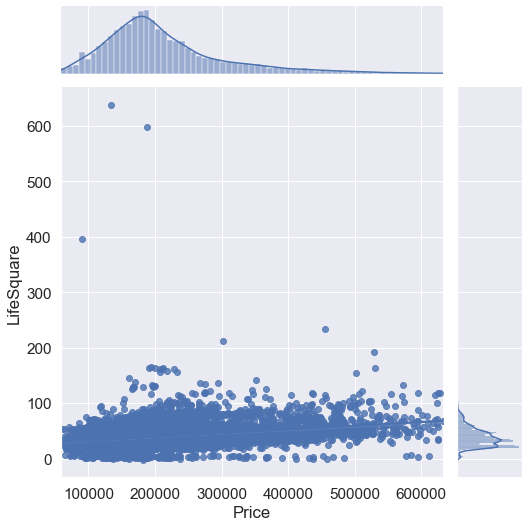

In [79]:
grid = sns.jointplot(train_df['Price'], train_df['LifeSquare'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

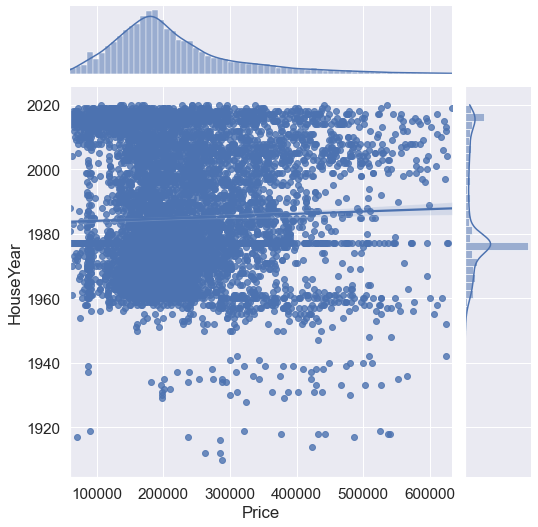

In [80]:
grid = sns.jointplot(train_df['Price'], train_df['HouseYear'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

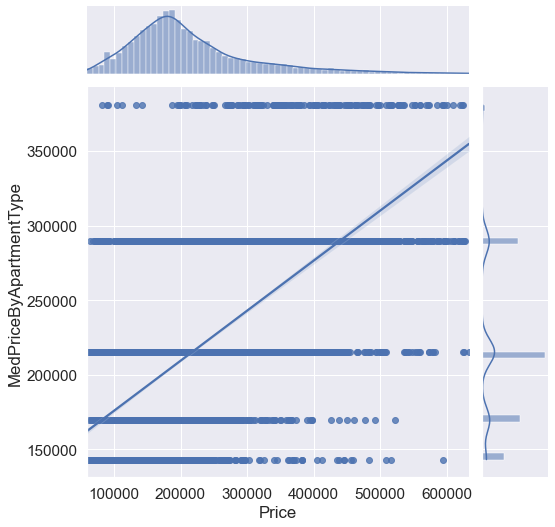

In [81]:
grid = sns.jointplot(train_df['Price'], train_df['MedPriceByApartmentType'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

In [82]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Apartment_type', 'MedPriceByApartmentType', 'New_building', 'Extreme_floors',
                    'Housing_class', 'MeanPriceSquareMeterByDistrict']

target_name = 'Price'

In [83]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [84]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [85]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 21), (3300, 21), (5000, 21))

In [86]:
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,LifeSquare_nan
9239,11585,23,1.0,43.380798,40.380798,0.0,18,25.0,1977,0.075779,...,B,6,1437,3,0,2,B,0,0,1
6930,2917,30,3.0,83.596365,77.596365,3.0,3,16.0,1977,0.000078,...,B,22,6398,141,3,23,B,0,0,1
8136,9635,47,2.0,53.610583,31.289235,8.0,2,12.0,1979,0.298205,...,B,16,4048,3,1,3,B,0,1,0
3424,8748,3,2.0,51.877576,30.075022,6.0,3,9.0,1974,0.265089,...,B,37,5288,0,3,2,B,0,0,0
6518,5704,62,1.0,53.810968,50.810968,0.0,1,1.0,1977,0.072158,...,B,2,629,1,0,0,A,0,1,1


In [87]:
features_gen = FeatureGenetator()
features_gen.Apartment_type_to_do(X_train)
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 27), (3300, 27), (5000, 27))

In [88]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [89]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### Построение модели

In [90]:
rf_model = GradientBoostingRegressor(criterion='mse',
                                 max_depth=19, # глубина дерева  
                                 min_samples_leaf=60, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42, 
                                 n_estimators=45  # кол-во деревьев
                                 )
rf_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=19, min_samples_leaf=60,
                          n_estimators=45, random_state=42)

### Оценка модели

Train R2:	0.833
Test R2:	0.75


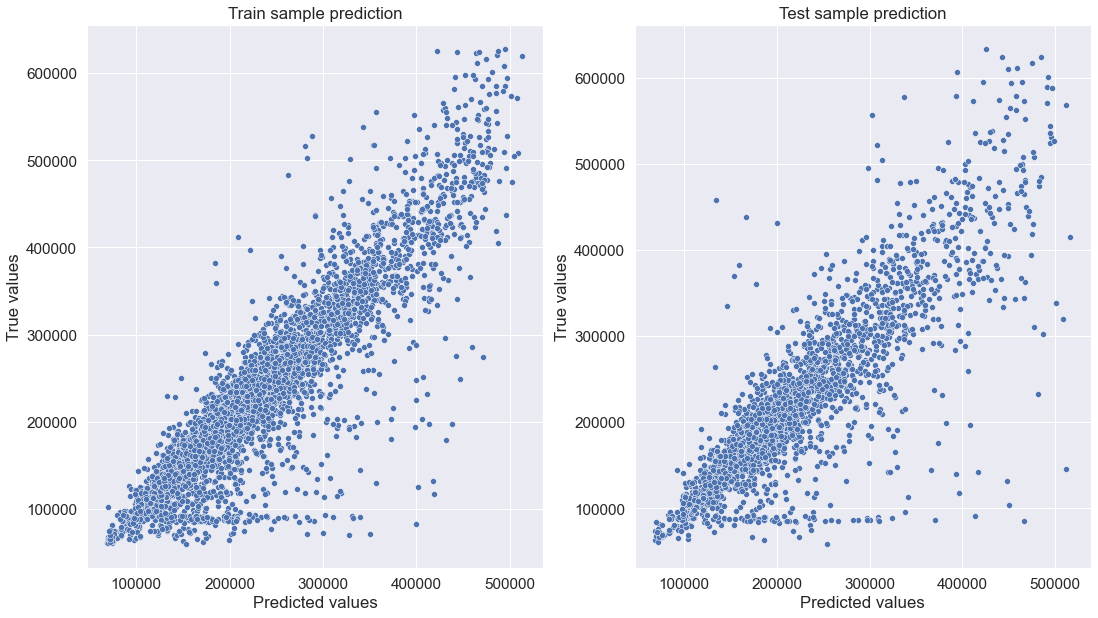

In [91]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

### Кросс-валидация

In [92]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.75960589, 0.71397448, 0.74800625])

In [93]:
cv_score.mean()

0.7405288719167977

#### Важность признаков

In [94]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.467617
21,MeanPriceSquareMeterByDistrict,0.387258
6,HouseYear,0.021122
12,Social_3,0.015240
2,LifeSquare,0.012971
0,Rooms,0.012469
11,Social_2,0.012200
7,Ecology_1,0.011519
5,HouseFloor,0.010214
10,Social_1,0.010010


### Прогнозирование на тестовом датасете

In [95]:
test_df.shape

(5000, 22)

In [96]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Social_3,Helthcare_2,Shops_1,Shops_2,Apartment_type,MedPriceByApartmentType,New_building,Extreme_floors,Housing_class,MeanPriceSquareMeterByDistrict
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,0,1,1,1,4,168988.144424,0,0,1,4566.815307
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,...,1,0,0,0,4,168988.144424,0,0,2,2903.265721
2,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,1,1,...,0,0,1,1,3,215072.380776,0,1,2,2859.643409
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,0,0,0,1,2,287983.862401,0,1,1,2288.820226
4,1.0,53.837056,50.837056,0.0,8,17.0,1977,0.309479,1,1,...,4,0,6,1,5,142482.643324,0,0,0,3411.583458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,5,5.0,1962,0.069660,1,1,...,4,1,2,1,3,215072.380776,1,1,1,4053.230799
4996,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,1,1,...,2,0,7,1,2,287983.862401,1,0,2,8634.687649
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,1,1,...,1,2,5,1,4,168988.144424,0,0,1,4198.877537
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,...,5,0,11,1,4,168988.144424,0,0,2,4450.429158


In [97]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [98]:
predictions = rf_model.predict(test_df)
predictions

array([169832.51991311, 126791.78202527, 151170.99173548, ...,
       150302.1221973 , 195811.2713944 , 266663.39831098])

In [99]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,169832.519913
1,5925,126791.782025
2,960,151170.991735
3,3848,114525.896751
4,746,181091.534124


In [100]:
submit.to_csv('rf_submit.csv', index=False)